In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import TensorDataset, DataLoader
import sys
import numpy as np
from numpy import load


# numpy.set_printoptions(threshold=sys.maxsize)

# Description of the Dataset

In [18]:
# Decription of the dataset
data = load('dataset.npz')
lst = data.files

print("x: Sequences \ny: Labels \n")

for item in lst:
    print(item)

print('\nSequences: ',data['x'].shape,'\nLabels', data['y'].shape)


x: Sequences 
y: Labels 

x
y
('\nSequences: ', (8920, 1182), '\nLabels', (8920,))


In [19]:
# temp = torch.zeros((16,16), dtype=torch.int)
# temp

# One Hot Encoding Conversion

In [20]:
'''
    One hot encoding function
    args: 'data'
            Type: a single np array (1182, 16)
    return: 'New Tensor'
            Takes the np array, finds the one hot encoding char
            Creates a new tensor and returns it (1182, 16, 16)
'''
def one_hot_encoded(data): #1182*16 to 1182*16*16
  new_tensor = torch.zeros((1182, 16,16))
  for i in range(data.shape[0]):
    row,col=data[i],data[i]
    new_tensor[i,row,col]=1
  return new_tensor

In [21]:
from tqdm import tqdm

In [23]:
# Convert all the sequences to one hot encoded matrices of size 16*16

# Load the sequences
new_data = data['x'].astype(int)
np.random.shuffle(new_data)
sequences_n = torch.zeros(new_data.shape[0], new_data.shape[1], 16,16)
print(sequences_n.size())

# Pass the sequences to one hot encoding function
for i in tqdm(range(new_data.shape[0])):
    sequences_n[i]=one_hot_encoded(new_data[i])
#     if(i%200 ==0):
#         print(i,' hogae')
print(sequences_n.size())

# Load and convert the labels to torch tensor
labels = torch.from_numpy(data['y'].astype(long))

  0%|          | 4/8920 [00:00<03:58, 37.32it/s]

torch.Size([8920, 1182, 16, 16])


100%|██████████| 8920/8920 [03:47<00:00, 39.24it/s]

torch.Size([8920, 1182, 16, 16])


# Creation of Dataloaders

In [24]:
# Create the dataset
full_dataset = TensorDataset(sequences_n, labels)

# Split the dataset
train_ds, test_ds = torch.utils.data.random_split(full_dataset, (6320, 2600))

# Print and confirm the dataset
# print(train_ds, test_ds)
# print(len(train_ds.indices), len(test_ds))
# print(train_ds.indices, test_ds.indices)

# Create the train data loader
train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

# Create the test data loader
test_dataloader = DataLoader(test_ds, batch_size=32, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)


# Creation of the Model

In [25]:


'''
    Type: RCPClass
    The class conatains the layers of the Dense and Transition blocks
    
    Args: Takes the dataset (batch size, sequence_size, w, h)
    return: Logits (Probabilities of the all 13 classes)
'''

# Create the RCPNet Class
class RPCNet(nn.Module):
  def __init__(self, in_channels):
    super(RPCNet, self).__init__()
    
    self.in_channels = in_channels
    self.conv1 = nn.Conv2d(in_channels=1182, out_channels=128, kernel_size=(16,17), padding=9)
    
    # First Dense Net Block
    self.DenseBlock1 = DenseBlock(128)
    
    # Second Dense Net Block
    self.DenseBlock2 = DenseBlock(256)
    
    # Third Dense Net Block
    self.DenseBlock3 = DenseBlock(512)
    
    # Transition Block 1
    self.pos_dense1 = nn.Sequential(
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(1,1)),
          nn.MaxPool2d(1,4))
    
    # Transition Block 2
    self.pos_dense2 = nn.Sequential(
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(1,1)),
          nn.MaxPool2d(1,4))
    
    # Transition Block 3
    self.pos_dense3 = nn.Sequential(
          nn.BatchNorm2d(512),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=(1,1)),
          nn.MaxPool2d(1,4))
    
    # Final linear layer, can be used with a Flatten Layer 
    self.f= nn.Flatten()
    self.Linear = nn.Linear(22528, 13)
      
  def forward(self, input):
    # input = input.reshape(input.size(0), input.size(2), input.size(1))
#     print(input.size())
    out = self.conv1(input)
#     print(out.size())
    
#     print("conv1 shape", out.size())
    weight = self.conv1.weight.data.cpu().numpy()
#     print("k:",weight.shape)

    out= self.DenseBlock1(out)

    out= self.pos_dense1(out)
#     print(out.size())

    out= self.DenseBlock2(out)
#     print(out.size())
    
    out = self.pos_dense2(out)
#     print(out.size())
    
    out= self.DenseBlock3(out)
#     print(out.size())
    
    out = self.pos_dense3(out)
#     print(out.size())
    
    logits = self.f(out)
    
    logits= self.Linear(logits)
#     print('logits size',logits.size())
#     print(logits)

    return logits

'''
    Type: Class DenseBlock
          Contains Batch Normalization, ReLU, Conv2D
          
    Input: Declaration: Num of input channels 
           Forward: Output of previous layer
    
    Can be used before transition blocks or other layers
'''
class DenseBlock(nn.Module):
  def __init__(self, num_features):
    super(DenseBlock, self).__init__()

    self.Block1 = Block(num_features) # applies relu and BN
    self.Block2 = Block(num_features)

  def forward(self, o_input):

    block1_res = self.Block1(o_input)
#     print("i and c in b ",block1_res.size(), o_input.size())
    block2_res = (torch.cat((block1_res, o_input), dim=2)) # o_inpu (concat) block1res
#     print(block2_res.size())
#     res = torch.cat((block1_res, block2_res, o_input), dim=2)
#     print(res.size())
    return  torch.cat((block1_res, block2_res, o_input), dim=2) # concat, block1_res, block2_res, o_input

'''
    Type: Block Class
    
    Input: Declaration: Num of input channels 
           Forward: Output of the previous layer
           
    return: Concatenated input and output of the BN, ReLU, Conv2D
'''

class Block(nn.Module):
  def __init__(self, num_features):
    super(Block, self).__init__()
    self.num_features = num_features

    self.BN = nn.BatchNorm2d(self.num_features) # try 2d
    self.conv1 = nn.Conv2d(in_channels=self.num_features, out_channels=num_features, kernel_size=(16,17), padding=8)
  
  def forward(self, input):
    res_relu = f.relu(self.BN(input))
    res_relu_conv = self.conv1(input)
#     print("w c block",self.conv1.weight.data.cpu().numpy().shape)

    return res_relu_conv

# Initializaiton of Model, Optimizer, Loss function 

In [26]:
model = RPCNet(1182)
model=model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Train Loop

In [27]:
total_loss_e = 0.0

plot_loss = []
for epoch in range(50):
    total_loss_i = 0
    total=0.0
    correct=0.0
    for i, batch in enumerate(train_dataloader):
        x,y=batch
        logits = model(x.cuda())
        loss = loss_function(logits,y.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss_i += loss.item()
        
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted.cpu() == y).sum().item()
        if i%50 ==0:
            print("Iter : {}  Train Loss : {}".format(i,loss.item()))
    total_loss_e+=total_loss_i/len(train_dataloader)
    print("Epoch  {} :   Train Loss : {}  Accuracy : {}".format(epoch, total_loss_e, (100 * (correct / total))))
    plot_loss.append(total_loss_e)
    total_loss_e=0
    

    



RuntimeError: CUDA out of memory. Tried to allocate 272.00 MiB (GPU 0; 31.74 GiB total capacity; 2.10 GiB already allocated; 183.19 MiB free; 2.18 GiB reserved in total by PyTorch)

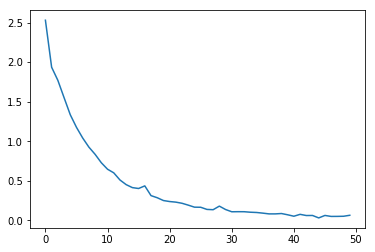

In [311]:
import matplotlib.pyplot as plt
plt.plot(plot_loss)
plt.show()

In [312]:
total_loss_i = 0
total=0.0
correct=0.0
model.eval()
for i, batch in enumerate(test_dataloader):
    x,y=batch
    logits = model(x.cuda())
    loss = loss_function(logits,y.cuda())
    total_loss_i += loss.item()
    _, predicted = torch.max(logits.data, 1)
    total += y.size(0)
    correct += (predicted.cpu() == y).sum().item()
    print("Iter : {}  Test Loss : {}".format(i,loss.item()))
    
# total_loss_e+=total_loss_i/len(test_dataloader)
print(" Accuracy : {}".format( (100 * (correct / total))))


Iter : 0  Test Loss : 2.94496107101
Iter : 1  Test Loss : 2.45704984665
Iter : 2  Test Loss : 2.03724956512
Iter : 3  Test Loss : 2.57082843781
Iter : 4  Test Loss : 5.34302186966
Iter : 5  Test Loss : 1.75534343719
Iter : 6  Test Loss : 1.78849947453
Iter : 7  Test Loss : 3.88453674316
Iter : 8  Test Loss : 2.37283420563
Iter : 9  Test Loss : 0.776594400406
Iter : 10  Test Loss : 5.25816011429
Iter : 11  Test Loss : 1.26096749306
Iter : 12  Test Loss : 3.16063666344
Iter : 13  Test Loss : 3.2196290493
Iter : 14  Test Loss : 2.58067417145
Iter : 15  Test Loss : 2.39291763306
Iter : 16  Test Loss : 2.45247483253
Iter : 17  Test Loss : 2.16455054283
Iter : 18  Test Loss : 2.19094610214
Iter : 19  Test Loss : 2.048869133
Iter : 20  Test Loss : 3.94749498367
Iter : 21  Test Loss : 1.6768206358
Iter : 22  Test Loss : 1.79274606705
Iter : 23  Test Loss : 2.600055933
Iter : 24  Test Loss : 4.39622020721
Iter : 25  Test Loss : 2.1419699192
Iter : 26  Test Loss : 1.97283899784
Iter : 27  Test L

# Test the Model

In [313]:
x,y = next(iter(test_dataloader))
print("Ground Truth:", y)
new_arr = x.cuda()
preds = model(new_arr)
print("Predictions", torch.max(preds, dim =1 ))


('Ground Truth:', tensor([ 4,  6,  3,  8,  2,  0,  9,  5,  6, 10, 11,  6,  6,  1,  3,  8,  6, 12,
         3,  0,  9,  2, 12,  0,  5,  5,  5,  4,  5,  0,  1, 11]))
('Predictions', torch.return_types.max(
values=tensor([14.4684, 85.1889,  9.1602,  8.8477,  4.4606, 36.2412,  6.6645, 22.4495,
        47.1942, 22.3329, 17.2882, 66.4394, 88.0309, 80.9064, 14.3579,  5.3693,
        91.5169, 37.7294, 11.4029, 55.8283, 18.3636, 18.2256, 37.0522, 48.3913,
        11.2702, 14.9665,  8.7802, 16.0170, 16.6690, 35.1423, 78.4830, 23.1582],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([ 4,  6,  8,  8, 11,  0,  4,  5,  6,  4, 11,  6,  6,  1,  3,  2,  6, 12,
         3,  0, 10,  2, 12,  0,  5,  4,  5,  9,  5,  0,  1, 11],
       device='cuda:0')))
